In [1]:
# 引入Python包，在jupyter notebook 运行后可以直接输出多个变量 注意大小写
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# 指定gpu设备
import os
os.environ['CUDA_VISIBLE_DEVICES'] ="0" # gpu
# os.environ["CUDA_VISIBLE_DEVICES"] = "-1" # cpu

In [2]:
from keras.applications import VGG16

Using TensorFlow backend.


In [3]:
type(VGG16)

function

In [4]:
model = VGG16(weights='imagenet', input_shape=(224, 224, 3))

In [5]:
model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [6]:
model = VGG16(weights='imagenet', include_top=False, input_shape=(150, 150, 3))

In [7]:
model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0     

In [8]:
import numpy as np
from keras.preprocessing.image import ImageDataGenerator

base_dir = 'kaggle-dogs-vs-cats/cats_and_dogs_small'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

datagen = ImageDataGenerator(rescale=1./255)
batch_size = 20

In [9]:
def extract_features(directory, sample_count):
    features = np.zeros(shape=(sample_count, 4, 4, 512))
    labels = np.zeros(shape=(sample_count))
    generator = datagen.flow_from_directory(
        directory,
        target_size=(150, 150),
        batch_size=batch_size,
        class_mode='binary')
    i = 0
    for input_batch, label_batch in generator:
        features_batch = model.predict(input_batch)
        features[i * batch_size : (i + 1) * batch_size] = features_batch
        labels[i * batch_size : (i + 1) * batch_size] = label_batch
        i += 1
        if i * batch_size >= sample_count:
            break
    return features, labels

In [10]:
train_features, train_labels = extract_features(train_dir, 2000)
validation_features, validation_labels = extract_features(validation_dir, 1000)
test_features, test_labels = extract_features(test_dir, 1000)

Found 2000 images belonging to 2 classes.

Found 1000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [11]:
train_features.shape
validation_features.shape
test_features.shape

(2000, 4, 4, 512)

(1000, 4, 4, 512)

(1000, 4, 4, 512)

In [12]:
train_features[0]

array([[[0.80065888, 0.        , 1.1060648 , ..., 0.        ,
         0.53441256, 0.        ],
        [0.64668846, 0.        , 0.90818465, ..., 0.        ,
         0.69984263, 0.        ],
        [0.23870873, 0.        , 0.27870795, ..., 0.        ,
         0.69098538, 0.        ],
        [0.29697788, 0.        , 0.4515028 , ..., 0.        ,
         0.15479043, 0.        ]],

       [[2.40164161, 0.        , 1.9210546 , ..., 0.        ,
         0.        , 0.        ],
        [1.62145996, 0.        , 1.88188839, ..., 0.        ,
         0.00438726, 0.        ],
        [0.        , 0.        , 0.54476517, ..., 0.        ,
         0.01568496, 0.        ],
        [1.05295753, 0.        , 0.29964536, ..., 0.        ,
         0.        , 0.        ]],

       [[2.5402019 , 0.        , 1.51824975, ..., 0.        ,
         0.        , 0.        ],
        [1.68583095, 0.        , 1.3622191 , ..., 0.        ,
         0.17470416, 0.        ],
        [0.15955879, 0.        , 0.0

In [13]:
train_features = np.reshape(train_features, (2000, 4 * 4 * 512))
validation_features = np.reshape(validation_features, (1000, 4 * 4 * 512))
test_features = np.reshape(test_features, (1000, 4 * 4 * 512))

In [14]:
import pickle
fw = open('07_train_features.bin', 'wb')
pickle.dump(train_features, fw)
fw.close()

fw = open('07_validation_features.bin', 'wb')
pickle.dump(validation_features, fw)
fw.close()

fw = open('07_test_features.bin', 'wb')
pickle.dump(test_features, fw)
fw.close()

In [15]:
from keras import models
from keras import layers
from keras import optimizers

dense_model = models.Sequential()
dense_model.add(layers.Dense(256, activation='relu', input_dim=4*4*512))
dense_model.add(layers.Dropout(0.5))
dense_model.add(layers.Dense(1, activation='sigmoid'))

dense_model.compile(optimizer=optimizers.RMSprop(lr=2e-5),
                   loss='binary_crossentropy',
                   metrics=['acc'])

history = dense_model.fit(train_features,
                          train_labels,
                          epochs=30,
                          batch_size=20,
                          validation_data=(validation_features, validation_labels))

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Train on 2000 samples, validate on 1000 samples
Epoch 1/30
2000/2000 [==============================] - 2s 1ms/step - loss: 0.6297 - acc: 0.6400 - val_loss: 0.4695 - val_acc: 0.7890
Epoch 2/30
2000/2000 [==============================] - 2s 804us/step - loss: 0.4366 - acc: 0.8000 - val_loss: 0.3699 - val_acc: 0.8510
Epoch 3/30
2000/2000 [==============================] - 2s 887us/step - loss: 0.3599 - acc: 0.8525 - val_loss: 0.3243 - val_acc: 0.8760
Epoch 4/30
2000/2000 [==============================] - 2s 983us/step - loss: 0.3146 - acc: 0.8680 - val_loss: 0.3009 - val_acc: 0.8920
Epoch 5/30
2000/2000 [==============================] - 3s 2ms/step - loss: 0.2820 - acc: 0.8895 - val_loss: 0.2825 - val_acc: 0.8960
Epoch 6/30
2000/2000 [==============================] - 2s 1ms/step - loss: 0.2643 - acc: 0.8975 - val_loss: 0.2718 - val_acc: 0.8930
Epoch 7/30
2000/2000 [==========================

In [16]:
dense_model.evaluate(test_features, test_labels)

1000/1000 [==============================] - 1s 581us/step


[0.26465104627609254, 0.8880000114440918]

Text(0.5, 1.0, 'Training and validation accuracy')

<Figure size 432x288 with 0 Axes>

Text(0.5, 1.0, 'Training and validation loss')

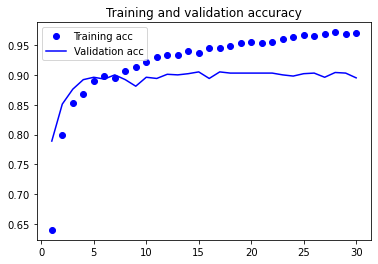

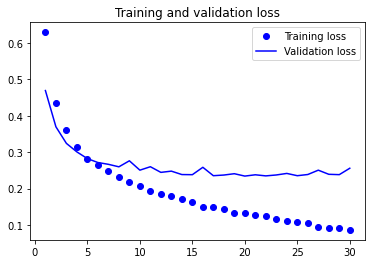

In [17]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1) 
 
plt.plot(epochs, acc, 'bo', label='Training acc') 
plt.plot(epochs, val_acc, 'b', label='Validation acc') 
plt.title('Training and validation accuracy') 
plt.legend() 
 
plt.figure() 
 
plt.plot(epochs, loss, 'bo', label='Training loss') 
plt.plot(epochs, val_loss, 'b', label='Validation loss') 
plt.title('Training and validation loss') 
plt.legend()

In [18]:
dense_model.save('cats_and_dogs_small_vgg16_01.h5')